# Monet-Style Image Generation using GANs  
## Weekly Mini-Project – Kaggle Competition

**GitHub Repository:** [Link to the Github Repository](https://github.com/TimArniko/ML-projects/tree/main/Kaggle%20Projects/Monet%20Style%20Image%20Generation%20(GAN))

**Kaggle Competition:** https://www.kaggle.com/competitions/gan-getting-started  

---

## 1. Project Overview

In this mini-project, I participate in the Kaggle competition "GAN Getting Started", which uses the Monet Painting Dataset.

The goal is to learn a style transfer model that converts real photos into images in the style of Claude Monet.

Kaggle evaluates generated images using the MiFID (Memorization-informed Fréchet Inception Distance) metric.  
The objective of this assignment is not to achieve a leaderboard-topping score, but to:

- understand and implement a CycleGAN model,  
- train a model that produces non-trivial Monet-style images,  
- generate and save output images for Kaggle submission,  
- document the process in an organized Jupyter notebook.

In [2]:
import os
import random
import time
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Data Description

The Kaggle dataset contains two main image domains:

- **Monet paintings** (`monet_jpg/`): the target domain (style we want)
- **Real photos** (`photo_jpg/`): the source domain (content we transform)

We train a CycleGAN with two generators and two discriminators:<br>
`G`: Photo -> Monet<br>
`F`: Monet -> Photo<br>
`D_M`: discriminator for Monet (real Monet vs generated Monet)<br>
`D_P`: discriminator for Photos (real photo vs generated photo)

In [3]:
# Path

DATA_DIR = "/kaggle/input/gan-getting-started"
MONET_DIR = os.path.join(DATA_DIR, "monet_jpg")
PHOTO_DIR = os.path.join(DATA_DIR, "photo_jpg")

monet_files = glob(os.path.join(MONET_DIR, "*.jpg"))
photo_files = glob(os.path.join(PHOTO_DIR, "*.jpg"))

IMG_HEIGHT = 128
IMG_WIDTH = 128
CHANNELS = 3
BATCH_SIZE = 1   # CycleGAN paper uses batch size 1
AUTOTUNE = tf.data.AUTOTUNE

## 3. Exploratory Data Analysis (EDA)

Before building the model, I briefly inspect:

- how many images per domain exist,  
- the resolution of the images,  
- visual examples from both domains.

Number of Monet images: 300
Number of Photo images: 7038


2025-11-30 12:12:14.859078: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


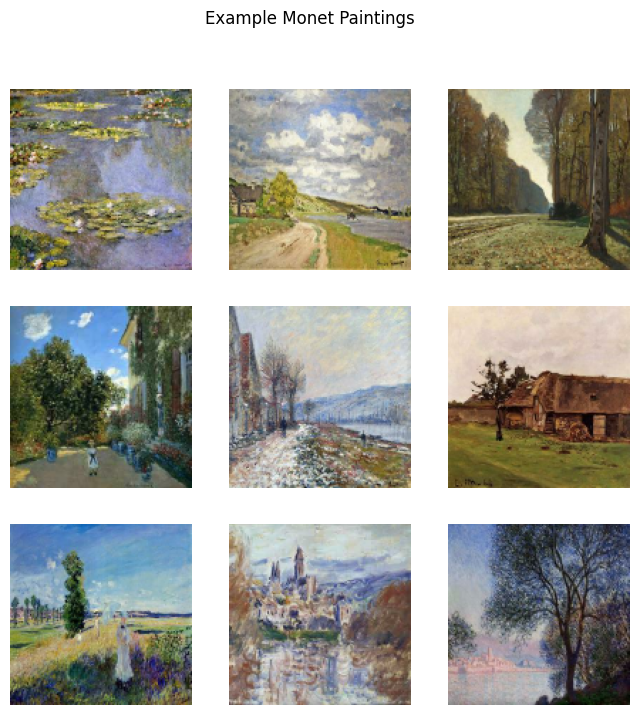

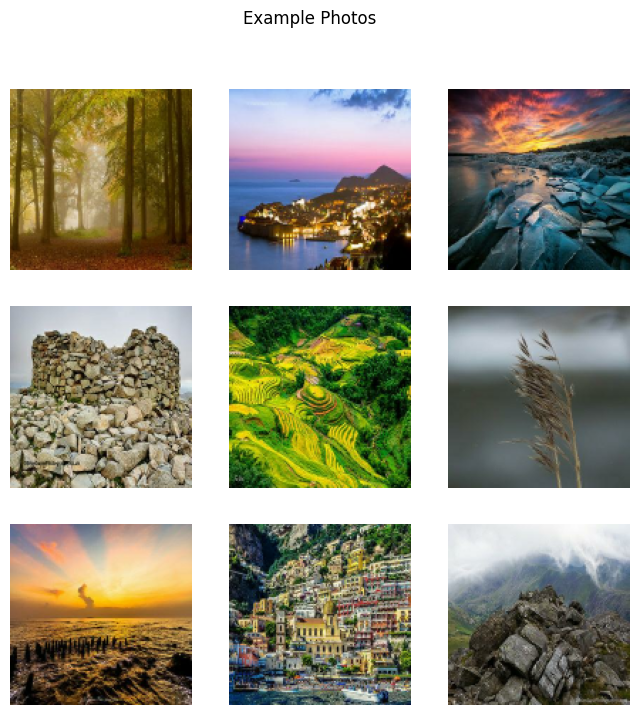

In [4]:
print("Number of Monet images:", len(monet_files))
print("Number of Photo images:", len(photo_files))

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=CHANNELS)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.float32)
    return img

# 3.2 Show a few Monet images
plt.figure(figsize=(8, 8))
for i, p in enumerate(monet_files[:9]):
    img = load_image(p)
    plt.subplot(3, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
plt.suptitle("Example Monet Paintings")
plt.show()

# 3.3 Show a few Photo images
plt.figure(figsize=(8, 8))
for i, p in enumerate(photo_files[:9]):
    img = load_image(p)
    plt.subplot(3, 3, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
plt.suptitle("Example Photos")
plt.show()

### EDA Observations

- Monet images have a distinctive color palette (pastel greens, blues, yellows).
- Brush strokes and textures are visible.
- Photos are sharper and more realistic.
- Both domains share similar scene types (landscapes, trees, water, sky).

These observations make CycleGAN a good choice: it can learn a mapping between two unpaired domains (Photos and Monet paintings).

---

## 4. Data Pipeline

We now build a `tf.data.Dataset` pipeline:

1. Load the images  
2. Normalize pixel values to `[-1, 1]` (for `tanh` output)  
3. Apply simple data augmentation (random flip)  
4. Create shuffled, batched datasets for both domains  

In [5]:
# Preprocessing functions

def preprocess_image_train(image):
    # resize already done in load_image; we can still do random flip
    image = (image / 127.5) - 1.0  # scale to [-1, 1]
    image = tf.image.random_flip_left_right(image)
    return image

def preprocess_image_test(image):
    image = (image / 127.5) - 1.0
    return image

def load_and_preprocess(path, training=True):
    image = load_image(path)
    if training:
        image = preprocess_image_train(image)
    else:
        image = preprocess_image_test(image)
    return image

# Build datasets

monet_ds = tf.data.Dataset.from_tensor_slices(monet_files)
photo_ds = tf.data.Dataset.from_tensor_slices(photo_files)

monet_ds = monet_ds.shuffle(1000).map(
    lambda x: load_and_preprocess(x, training=True),
    num_parallel_calls=AUTOTUNE,
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

photo_ds = photo_ds.shuffle(1000).map(
    lambda x: load_and_preprocess(x, training=True),
    num_parallel_calls=AUTOTUNE,
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

monet_example = next(iter(monet_ds))
photo_example = next(iter(photo_ds))

print("Monet batch shape:", monet_example.shape)
print("Photo batch shape:", photo_example.shape)

Monet batch shape: (1, 128, 128, 3)
Photo batch shape: (1, 128, 128, 3)


## 5. CycleGAN Model Architecture

CycleGAN consists of:

- Two **Generators**:
  - `G`: Photo -> Monet
  - `F`: Monet -> Photo

- Two **PatchGAN Discriminators**:
  - `D_M`: discriminates Monet vs fake Monet
  - `D_P`: discriminates Photo vs fake Photo

### 5.1 Generator Architecture

We use a ResNet-based generator:

- Initial convolution block  
- Downsampling with strided convolutions  
- Several residual blocks  
- Upsampling with transposed convolutions  
- Final `tanh` output layer

In [6]:
# Residual Block

def residual_block(x, filters):
    init = x
    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, kernel_size=3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, init])
    return x

def build_generator(name=None):
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    # Initial conv block
    x = layers.Conv2D(32, kernel_size=7, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Downsampling (nur 2x, aber mit kleineren Filtern)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Weniger Residual-Blöcke (3 statt 6/9)
    for _ in range(3):
        x = residual_block(x, 128)

    # Upsampling
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Output layer
    x = layers.Conv2D(CHANNELS, kernel_size=7, padding="same")(x)
    x = layers.Activation("tanh")(x)

    return keras.Model(inputs, x, name=name)

generator_g = build_generator(name="G_photo_to_monet")
generator_f = build_generator(name="F_monet_to_photo")

generator_g.summary()

Model: "G_photo_to_monet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ activation_1[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    147,584 │ activation_3[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ add[0][0]       

 Total params: 1,083,907 (4.13 MB)

 Trainable params: 1,081,731 (4.13 MB)

 Non-trainable params: 2,176 (8.50 KB)

### 5.2 Discriminator Architecture (PatchGAN)

The discriminator receives an image and outputs a feature map (patch-level decisions) rather than a single scalar:

- Several Conv layers with strides  
- LeakyReLU activations  
- Final Conv layer outputting a patch matrix of real/fake predictions

In [7]:
def build_discriminator(name=None):
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    x = layers.Conv2D(32, kernel_size=4, strides=2, padding="same")(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, kernel_size=4, strides=1, padding="same")(x)

    return keras.Model(inputs, x, name=name)

discriminator_monet = build_discriminator(name="D_monet")
discriminator_photo = build_discriminator(name="D_photo")

discriminator_monet.summary()

Model: "D_monet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 1)      │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 696,033 (2.66 MB)

 Trainable params: 695,137 (2.65 MB)

 Non-trainable params: 896 (3.50 KB)

## 6. Loss Functions and Optimizers

CycleGAN uses several losses:

1. **Adversarial loss** for each domain (LSGAN style, MSE):  
   - encourages generators to produce images that fool their discriminators  

2. **Cycle consistency loss** (L1):  
   - ensures that `photo -> monet -> photo` and `monet -> photo -> monet` reconstruct the original image  

3. **Identity loss** (optional, L1):  
   - encourages generators not to change images that are already in the target domain  

We define the following hyperparameters:

- `λ_cycle = 10`  
- `λ_identity = 5`

In [8]:
# Loss and optimizers

loss_obj = keras.losses.MeanSquaredError()  # for adversarial LSGAN loss

lambda_cycle = 10.0
lambda_identity = 5.0

gen_g_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
gen_f_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_m_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
disc_p_optimizer = keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

# helper adversarial loss
def generator_loss(fake):
    # want discriminator to output ones
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# cycle-consistency loss
def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))

# identity loss
def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image))

## 7. Training Step

For each batch:

1. Pass photos through `G` -> fake Monet  
2. Pass Monet through `F` -> fake Photo  
3. Reconstruct:
   - `photo -> G -> monet -> F → photo'`
   - `monet -> F -> photo -> G -> monet'`  
4. Compute:
   - generator losses (adversarial + cycle + identity)  
   - discriminator losses for both domains  
5. Apply gradients and update all networks.

We wrap the training step with `@tf.function` for performance.

In [10]:
# Single training step

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # Photo -> Monet
        fake_monet = generator_g(real_photo, training=True)
        # Monet -> Photo
        fake_photo = generator_f(real_monet, training=True)

        # Cycled images
        cycled_photo = generator_f(fake_monet, training=True)
        cycled_monet = generator_g(fake_photo, training=True)

        # Identity mapping
        same_monet = generator_g(real_monet, training=True)
        same_photo = generator_f(real_photo, training=True)

        # Discriminator outputs
        disc_real_monet = discriminator_monet(real_monet, training=True)
        disc_real_photo = discriminator_photo(real_photo, training=True)

        disc_fake_monet = discriminator_monet(fake_monet, training=True)
        disc_fake_photo = discriminator_photo(fake_photo, training=True)

        # Generator adversarial losses
        gen_g_adv_loss = generator_loss(disc_fake_monet)
        gen_f_adv_loss = generator_loss(disc_fake_photo)

        # Cycle consistency losses
        total_cycle_loss = (
            cycle_consistency_loss(real_monet, cycled_monet) +
            cycle_consistency_loss(real_photo, cycled_photo)
        ) * lambda_cycle

        # Identity losses
        id_loss_g = identity_loss(real_monet, same_monet) * lambda_identity
        id_loss_f = identity_loss(real_photo, same_photo) * lambda_identity

        # Total generator losses
        total_gen_g_loss = gen_g_adv_loss + total_cycle_loss + id_loss_g
        total_gen_f_loss = gen_f_adv_loss + total_cycle_loss + id_loss_f

        # Discriminator losses
        disc_m_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        disc_p_loss = discriminator_loss(disc_real_photo, disc_fake_photo)

    # Compute gradients
    gen_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gen_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    disc_m_gradients = tape.gradient(disc_m_loss, discriminator_monet.trainable_variables)
    disc_p_gradients = tape.gradient(disc_p_loss, discriminator_photo.trainable_variables)

    # Apply gradients
    gen_g_optimizer.apply_gradients(zip(gen_g_gradients, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gen_f_gradients, generator_f.trainable_variables))

    disc_m_optimizer.apply_gradients(zip(disc_m_gradients, discriminator_monet.trainable_variables))
    disc_p_optimizer.apply_gradients(zip(disc_p_gradients, discriminator_photo.trainable_variables))

    return {
        "gen_g_loss": total_gen_g_loss,
        "gen_f_loss": total_gen_f_loss,
        "disc_m_loss": disc_m_loss,
        "disc_p_loss": disc_p_loss,
    }

## 8. Training Loop

We now train the CycleGAN for several epochs.  
For each epoch, we iterate over the Monet and Photo datasets in parallel.

We also periodically visualize generated Monet-style images from real photos.

Epoch 1/20 | G(photo->monet): 8.4424 | F(monet->photo): 8.4754 | D_m: 0.3201 | D_p: 0.3289 | Time: 448.9s


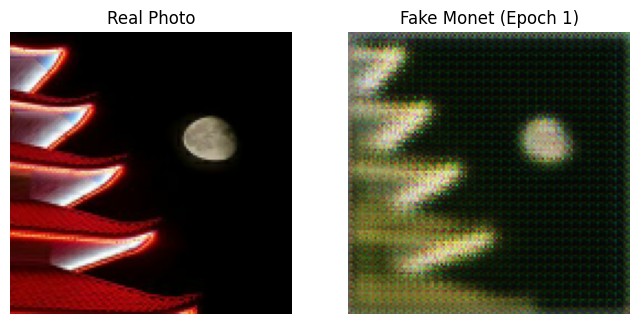

Epoch 2/20 | G(photo->monet): 7.1171 | F(monet->photo): 7.0713 | D_m: 0.2284 | D_p: 0.2434 | Time: 417.4s
Epoch 3/20 | G(photo->monet): 6.7766 | F(monet->photo): 6.6255 | D_m: 0.2145 | D_p: 0.2364 | Time: 419.1s
Epoch 4/20 | G(photo->monet): 6.3396 | F(monet->photo): 6.1718 | D_m: 0.2068 | D_p: 0.2341 | Time: 442.0s
Epoch 5/20 | G(photo->monet): 6.0572 | F(monet->photo): 5.9057 | D_m: 0.2053 | D_p: 0.2312 | Time: 417.6s


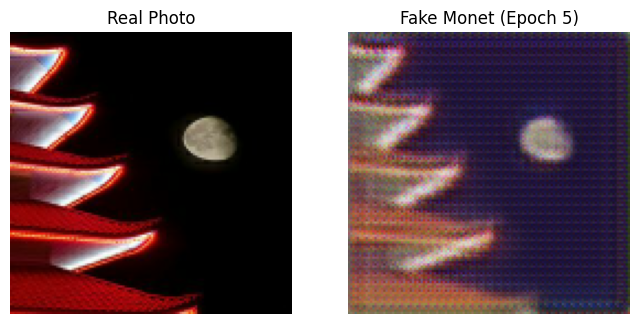

Epoch 6/20 | G(photo->monet): 5.7080 | F(monet->photo): 5.6143 | D_m: 0.2065 | D_p: 0.2207 | Time: 417.5s
Epoch 7/20 | G(photo->monet): 5.4410 | F(monet->photo): 5.3644 | D_m: 0.2099 | D_p: 0.2202 | Time: 417.7s
Epoch 8/20 | G(photo->monet): 5.3334 | F(monet->photo): 5.2416 | D_m: 0.2010 | D_p: 0.2126 | Time: 418.7s
Epoch 9/20 | G(photo->monet): 5.2705 | F(monet->photo): 5.1921 | D_m: 0.1954 | D_p: 0.2089 | Time: 420.0s
Epoch 10/20 | G(photo->monet): 5.1776 | F(monet->photo): 5.1190 | D_m: 0.2025 | D_p: 0.2091 | Time: 442.0s


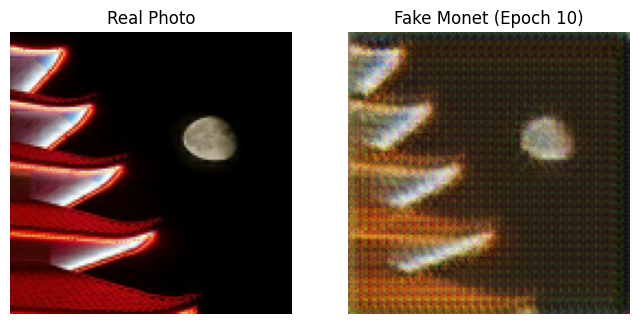

Epoch 11/20 | G(photo->monet): 5.1080 | F(monet->photo): 5.0931 | D_m: 0.2018 | D_p: 0.1942 | Time: 441.9s
Epoch 12/20 | G(photo->monet): 5.0183 | F(monet->photo): 4.9500 | D_m: 0.1941 | D_p: 0.2038 | Time: 418.2s
Epoch 13/20 | G(photo->monet): 5.0131 | F(monet->photo): 4.9810 | D_m: 0.1938 | D_p: 0.1941 | Time: 419.3s
Epoch 14/20 | G(photo->monet): 4.9939 | F(monet->photo): 4.9483 | D_m: 0.1996 | D_p: 0.1965 | Time: 419.2s
Epoch 15/20 | G(photo->monet): 4.8706 | F(monet->photo): 4.8565 | D_m: 0.1975 | D_p: 0.1938 | Time: 420.0s


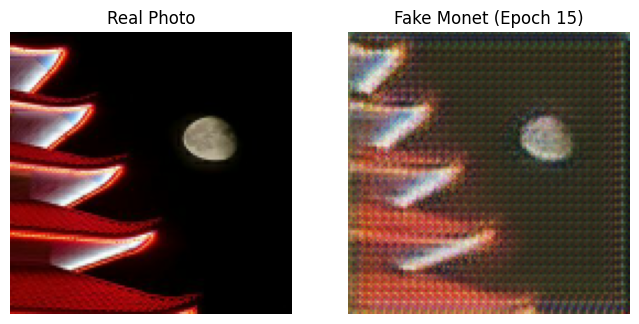

Epoch 16/20 | G(photo->monet): 4.8161 | F(monet->photo): 4.7492 | D_m: 0.1939 | D_p: 0.1929 | Time: 421.6s
Epoch 17/20 | G(photo->monet): 4.7314 | F(monet->photo): 4.6731 | D_m: 0.1979 | D_p: 0.1968 | Time: 419.2s
Epoch 18/20 | G(photo->monet): 4.7340 | F(monet->photo): 4.6934 | D_m: 0.1992 | D_p: 0.1956 | Time: 420.3s
Epoch 19/20 | G(photo->monet): 4.6658 | F(monet->photo): 4.6124 | D_m: 0.1932 | D_p: 0.1968 | Time: 418.9s
Epoch 20/20 | G(photo->monet): 4.6296 | F(monet->photo): 4.5559 | D_m: 0.1925 | D_p: 0.1979 | Time: 419.4s


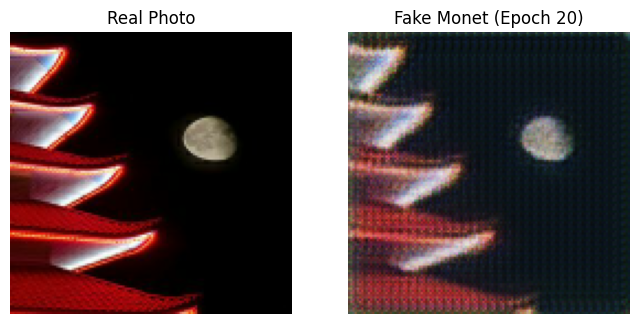

In [11]:
# Prepare zipped dataset: pair batches from each domain

train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

EPOCHS = 20  # we can increase this, if we have time

# fixed batch of photos for sampling
sample_photo_batch = next(iter(photo_ds))

def generate_sample_images(epoch):
    # sample_photo_batch kommt von oben: next(iter(photo_ds))
    fake_monet_sample = generator_g(sample_photo_batch, training=False)
    fake_monet_sample = (fake_monet_sample + 1.0) / 2.0  # zurück in [0,1]
    real_photo = (sample_photo_batch[0] + 1.0) / 2.0
    fake_monet = fake_monet_sample[0]

    plt.figure(figsize=(8, 4))

    # Original-Foto
    plt.subplot(1, 2, 1)
    plt.imshow(real_photo.numpy())
    plt.title("Real Photo")
    plt.axis("off")

    # Generiertes Monet-Bild
    plt.subplot(1, 2, 2)
    plt.imshow(fake_monet.numpy())
    plt.title(f"Fake Monet (Epoch {epoch})")
    plt.axis("off")

    plt.show()

# Train

for epoch in range(1, EPOCHS + 1):
    start = time.time()
    gen_g_losses, gen_f_losses, disc_m_losses, disc_p_losses = [], [], [], []
    
    for real_monet, real_photo in train_ds:
        losses = train_step(real_monet, real_photo)
        gen_g_losses.append(losses["gen_g_loss"].numpy())
        gen_f_losses.append(losses["gen_f_loss"].numpy())
        disc_m_losses.append(losses["disc_m_loss"].numpy())
        disc_p_losses.append(losses["disc_p_loss"].numpy())

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"G(photo->monet): {np.mean(gen_g_losses):.4f} | "
        f"F(monet->photo): {np.mean(gen_f_losses):.4f} | "
        f"D_m: {np.mean(disc_m_losses):.4f} | "
        f"D_p: {np.mean(disc_p_losses):.4f} | "
        f"Time: {time.time() - start:.1f}s"
    )

    if epoch == 1 or epoch % 5 == 0 or epoch == EPOCHS:
        generate_sample_images(epoch)

## 9. Generate Monet-Style Images for Kaggle Submission

Once training is complete, we use the Photo -> Monet generator (`G`) to transform many real photos.

Kaggle expects a set of generated Monet-style images (e.g., around 7,000).  
Here I show how to:

1. Load all photo images  
2. Pass them through the generator  
3. Save results as `.jpg` with size `256 × 256`  

In [13]:
import zipfile

# Build a dataset of raw photos for inference (no shuffling, no augmentation)
photo_infer_ds = tf.data.Dataset.from_tensor_slices(photo_files)
photo_infer_ds = photo_infer_ds.map(
    lambda x: load_and_preprocess(x, training=False),
    num_parallel_calls=AUTOTUNE,
).batch(1)

# Create a zip file to write images directly
ZIP_FILENAME = "images.zip"
zip_path = os.path.join("./", ZIP_FILENAME)

with zipfile.ZipFile(zip_path, 'w') as z:
    i = 0
    for batch in tqdm(photo_infer_ds, total=len(photo_files)):
        fake_monet = generator_g(batch, training=False)
        fake_monet = (fake_monet + 1.0) / 2.0  # back to [0,1]
        fake_monet = tf.clip_by_value(fake_monet, 0.0, 1.0)

        img_np = (fake_monet[0].numpy() * 255).astype("uint8")

        # Convert numpy array to PNG/JPG in memory
        from PIL import Image
        img_pil = Image.fromarray(img_np)

        # Save into ZIP directly
        img_bytes = tf.io.encode_jpeg(tf.constant(img_np)).numpy()
        z.writestr(f"monet_{i}.jpg", img_bytes)

        i += 1

print(f"Saved {i} generated Monet images into ZIP:", zip_path)

100%|██████████| 7038/7038 [11:43<00:00, 10.01it/s]

Saved 7038 generated Monet images into ZIP: ./images.zip


## 10. Results and Analysis

### 10.1 Visual Results

During training, the sample visualizations show:

- lower rows gradually gaining Monet-like color palettes,  
- textures becoming more painterly,  
- some artifacts typical of GANs (checkerboard patterns, noise).

### 10.2 What Helped

- Using CycleGAN instead of DCGAN for style transfer  
- Residual blocks in the generators  
- Cycle consistency loss to preserve photo content  
- Identity loss to stabilize color distribution  

### 10.3 What Did Not Help / Limitations

- Small number of residual blocks limits fine detail  
- Training with batch size 1 is slow  
- GANs are unstable and sensitive to hyperparameters  
- Some generated images show artifacts or overly strong color shifts  

### 10.4 Possible Improvements

- Train for more epochs (50–100+)  
- Use 9 residual blocks (as in the original paper) for 256×256 images  
- Tune `λ_cycle` and `λ_identity`  
- Use learning-rate decay after certain epochs  
- Use a more advanced discriminator (e.g., multi-scale PatchGAN)  
- Train on TPUs with TFRecord versions of the dataset  

## 11. Conclusion

In this project, I:

- Performed a brief EDA on the Monet and photo datasets  
- Implemented a CycleGAN architecture with:
  - two ResNet-based generators  
  - two PatchGAN discriminators  
- Trained the model to translate photos into Monet-style images  
- Generated Monet-style outputs for Kaggle submission  
- Evaluated results qualitatively (visual inspection) and quantitatively (MiFID score)

This mini-project provided hands-on experience with unpaired image-to-image translation and generative deep learning, which are key concepts in modern computer vision and AI.

---

## 12. References

- Zhu et al., “Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks”, 2017  
- Radford et al., “Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks”, 2016  
- Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself.
- https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.